# Machine Learning in Python - Project 2

Due Friday, Apr 11th by 4 pm.

Group member:
Dejie Li , Xingshen Chen

## Setup

*Install any packages here, define any functions if neeed, and load data*

In [5]:
# Add any additional libraries or submodules below

# Data libraries
import pandas as pd
import numpy as np
import math

# data cleaning
import missingno as msno

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [2]:
# helper function
def get_coefs(m):
    """Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available. This function is extracted from workshop5 code.
    """
    
    # If pipeline, use the last step as the model
    if (isinstance(m, sklearn.pipeline.Pipeline)):
        m = m.steps[-1][1]
    
    
    if m.intercept_ is None:
        return m.coef_
    
    return np.concatenate([[m.intercept_], m.coef_])

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def classification_model_fit(model, X_test, y_test, model_name="Model"):
    """
    评估二分类模型的性能并绘制混淆矩阵。
    
    参数：
    model      : 拟合好的 sklearn 分类模型（如逻辑回归）
    X_test     : 测试集特征
    y_test     : 测试集标签（真实值）
    model_name : 可选，显示在图标题上的模型名
    """

    # 获取预测值
    y_pred = model.predict(X_test)
    
    # 获取预测概率（用于 ROC AUC）
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.decision_function(X_test)

    # 计算评估指标
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print(f"📊 评估指标 ({model_name})")
    print("-" * 30)
    print(f"Accuracy       : {acc:.4f}")
    print(f"Precision      : {prec:.4f}")
    print(f"Recall         : {rec:.4f}")
    print(f"F1 Score       : {f1:.4f}")
    print(f"ROC AUC Score  : {auc:.4f}")

    # 混淆矩阵
    cm = confusion_matrix(y_test, y_pred)
    labels = ['Prepaid (0)', 'Default (1)']

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.title(f'{model_name} - Confusion Matrix', fontsize=14)
    plt.show()

    # 可选：返回指标字典
    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": auc,
        "confusion_matrix": cm
    }


# Introduction


### 1.1 Research Background and Significance
Credit default risk assessment is a crucial task in the credit industry. An effective default prediction model can help financial institutions identify high-risk borrowers, reduce losses from non-performing loans, and enhance the fairness and accuracy of credit decision-making. With the growing availability of data, machine learning-based risk modeling has become increasingly popular. This project aims to develop an interpretable classification model to predict loan defaults and identify key factors contributing to the likelihood of default, thereby supporting data-driven decisions in credit risk management.

### 1.2 Data Source
The dataset used in this study comes from the Freddie Mac Single-Family Loan-Level Dataset. We use a simplified version focusing on the years 2017 to 2020. It includes detailed loan-level information such as borrower credit scores, loan terms, property characteristics, geographic location, loan-to-value ratios, and repayment statuses. The target variable, loan_status, contains three possible values: default, prepaid, and active. Special codes such as 999 and 9 are used to indicate missing values in some features, and we apply data cleaning and imputation strategies during preprocessing to handle them appropriately.

### 1.3 Research Objective
The primary goal of this project is to build a classification model that accurately predicts the probability of loan default. We first extract all loans labeled as either default or prepaid and split them into training and test sets for model development and evaluation. Once validated, the trained model is then applied to the remaining active loans to predict potential defaults. Additionally, we aim to identify and interpret the most important predictors of loan default to support more informed credit risk assessments and policy design.

### 1.4 Methodology

### 1.5 Conclusion

# Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling. Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. Think carefully about whether each plot needs to be included in your final draft and the appropriate type of plot and summary for each variable type - your report should include figures but they should be as focused and impactful as possible.*

*You should also split your data into training and testing sets, ideally before you look to much into the features and relationships with the target*

*Additionally, this section should also motivate and describe any preprocessing / feature engineering of the data. Specifically, this should be any code that you use to generate new columns in the data frame `d`. Pipelines should be used and feature engineering steps that are be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

*All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.*

## 2.1 Dataset Feature Desctiptions
The dataset used in this project originates from a mortgage loan performance dataset released by Fannie Mae, a government-sponsored enterprise in the United States. It includes detailed information about mortgage loans issued over multiple years, covering borrower characteristics, loan terms, property features, and loan performance outcomes such as whether the loan was prepaid or defaulted.



In [57]:
# We load the data below
d = pd.read_csv("freddiemac.csv")
d.head()

/tmp/ipykernel_81677/1786613892.py:2: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  d = pd.read_csv("freddiemac.csv")


,fico,dt_first_pi,flag_fthb,dt_matr,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,dti,...,seller_name,servicer_name,flag_sc,id_loan_rr,program_ind,rr_ind,property_val,io_ind,mi_cancel_ind,loan_status
0,809,201705,N,204704,NaN,0,1,P,75,38,...,Other sellers,SPECIALIZED LOAN SERVICING LLC,NaN,NaN,9,NaN,2,N,7,prepaid
1,702,201703,N,203202,NaN,0,1,P,80,36,...,Other sellers,Other servicers,NaN,NaN,9,NaN,2,N,7,active
2,792,201703,N,204702,NaN,0,1,S,60,36,...,Other sellers,Other servicers,NaN,NaN,9,NaN,2,N,7,prepaid
3,776,201703,N,204702,NaN,0,1,S,80,18,...,Other sellers,Other servicers,NaN,NaN,9,NaN,2,N,7,prepaid
4,790,201703,N,204702,41620.0,0,1,I,75,42,...,Other sellers,"PNC BANK, NA",NaN,NaN,9,NaN,2,N,7,active


We have the following numerical features in our data:

- **fico**: Credit score of the borrower at origination.  
- **dt_first_pi**: First payment date (YYYYMM).  
- **dt_matr**: Scheduled loan maturity date.  
- **mi_pct**: Mortgage insurance percentage.  
- **cltv**: Combined loan-to-value ratio.  
- **dti**: Debt-to-income ratio.  
- **orig_upb**: Original unpaid principal balance.  
- **ltv**: Loan-to-value ratio at origination.  
- **int_rt**: Interest rate of the loan.  
- **orig_loan_term**: Original term length of the loan (in months).  

We have the following categorical features in our data

- **flag_fthb**: First-time homebuyer indicator.  
- **occpy_sts**: Occupancy status of the property.  
- **channel**: Loan origination channel.  
- **st**: State where the property is located.  
- **prop_type**: Property type.  
- **loan_purpose**: Purpose of the loan.  
- **seller_name**: Seller of the loan.  
- **servicer_name**: Entity servicing the loan.  
- **flag_sc**: Super conforming loan indicator.  
- **program_ind**: Loan program indicator.  
- **rr_ind**: Re-performing refinance indicator.  
- **cd_msa**: Metro area indicator.  
- **cnt_borr**: Number of borrowers.  
- **property_val**: Property valuation method.  
- **mi_cancel_ind**: Mortgage insurance cancellation status.  
- **cnt_units**: Number of housing units.

- We excluded non-feature columns such as **ID** and **loan_status**, as they are either identifiers or already used to define the target variable.
- We dropped the columns **ppnt_pnlty**, **prod_type**, and **io_ind** because each of them contains only a single unique value across all loans, providing no variance or predictive power for modeling.
- The **zipcode** column was also discarded. Although it could represent geographic information, we already included the state abbreviation (**st**) as a regional indicator. Using **zipcode** as a numeric variable is not meaningful, and treating it as a categorical variable would introduce too many levels, which is inappropriate for most machine learning models.

## 2.2 Handing Missing Data

In this dataset, missing values are not consistently represented as standard `NaN`, but are instead encoded using placeholder values such as `9`, `99`, `999`, or `9999`, depending on the column. 

To facilitate consistent missing value handling in the preprocessing stage, we first created a mapping (`missing_value_map`) that specifies which placeholder values correspond to missing data for each relevant column. 

We then applied this mapping across the dataset to replace all these special codes with proper `NaN` values using the `.replace()` function. This ensures that later stages of analysis and imputation can recognize and treat these entries as standard missing data.

In [58]:
# define missing value map
missing_value_map = {
    'fico': [9999],
    'mi_pct': [999],
    'cltv': [999],
    'dti': [999],
    'ltv': [999],
    'flag_fthb': ['9'],
    'occpy_sts': ['9'],
    'channel': ['9'],
    'prop_type': ['99'],
    'loan_purpose': ['9'],
    'program_ind': ['9'],
    'rr_ind': ['9'],
    'cnt_borr': ['9'],
    'property_val': ['9'],
    'mi_cancel_ind': ['9'],
    'cnt_units': ['99']
}

# replace
for col, missing_vals in missing_value_map.items():
    d[col] = d[col].replace(missing_vals, np.nan)

In [ ]:
# have a overview of dataset and missing value
d.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 33 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   fico            199959 non-null  float64
 1   dt_first_pi     200000 non-null  int64  
 2   flag_fthb       200000 non-null  object 
 3   dt_matr         200000 non-null  int64  
 4   cd_msa          181072 non-null  float64
 5   mi_pct          199999 non-null  float64
 6   cnt_units       200000 non-null  int64  
 7   occpy_sts       200000 non-null  object 
 8   cltv            199994 non-null  float64
 9   dti             197588 non-null  float64
 10  orig_upb        200000 non-null  int64  
 11  ltv             199998 non-null  float64
 12  int_rt          200000 non-null  float64
 13  channel         200000 non-null  object 
 14  ppmt_pnlty      200000 non-null  object 
 15  prod_type       200000 non-null  object 
 16  st              200000 non-null  object 
 17  prop_type 

Before deciding how to handle missing values in our mortgage dataset, we first assessed the extent and nature of the missingness.
To understand whether dropping or imputing missing values is appropriate, we visualized the missing value matrix. This step helped us identify patterns and determine if the missingness appears random or systematic, which informs our later decision-making on imputation strategies or variable removal.

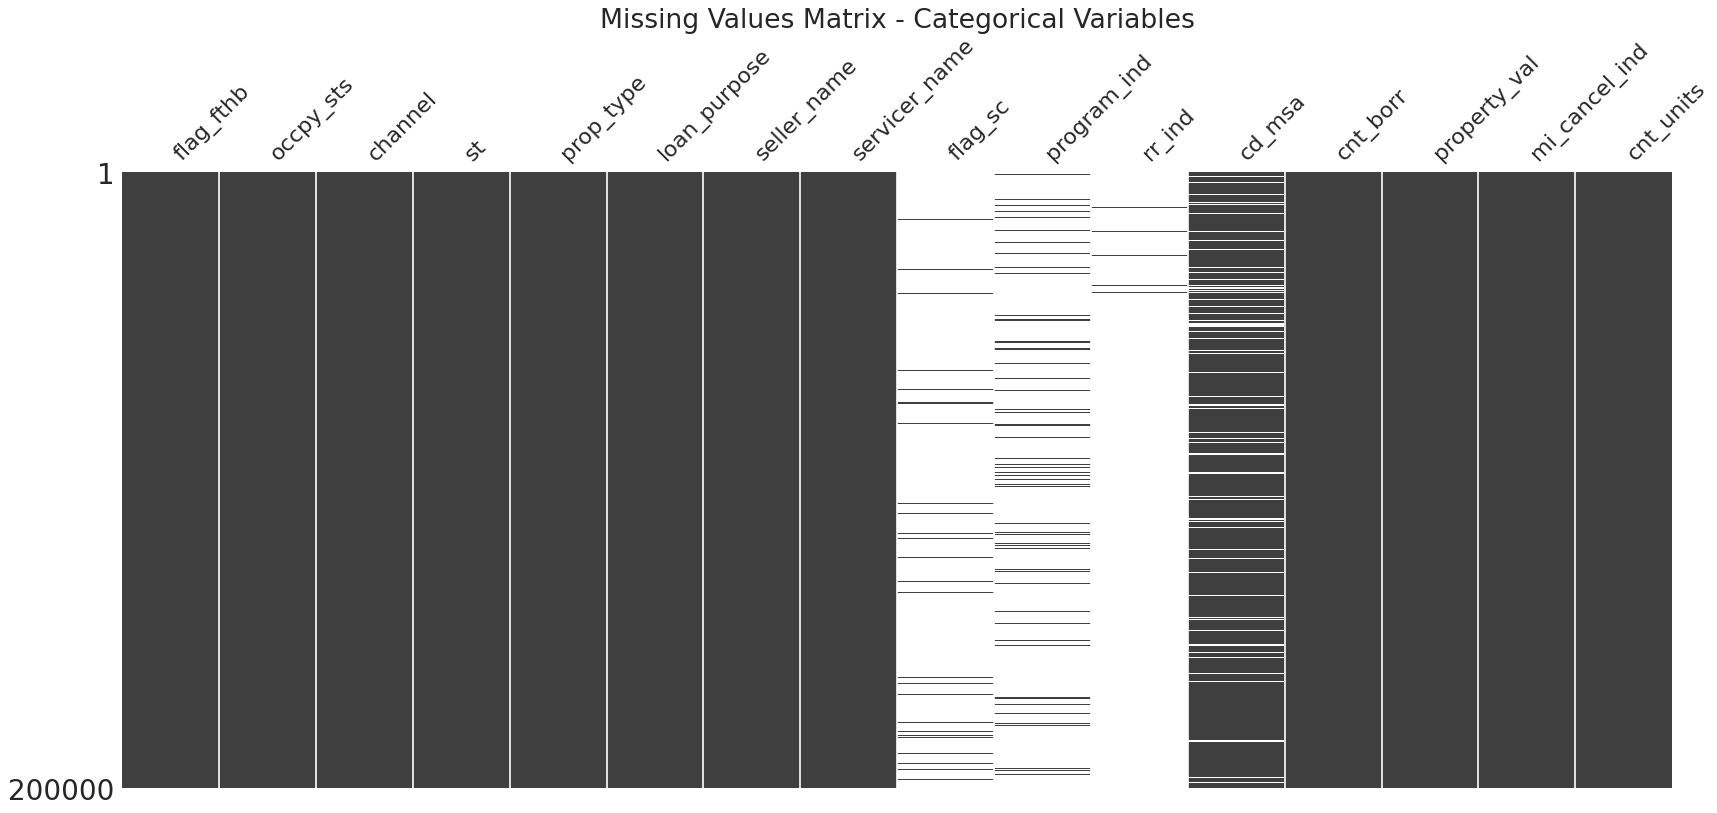

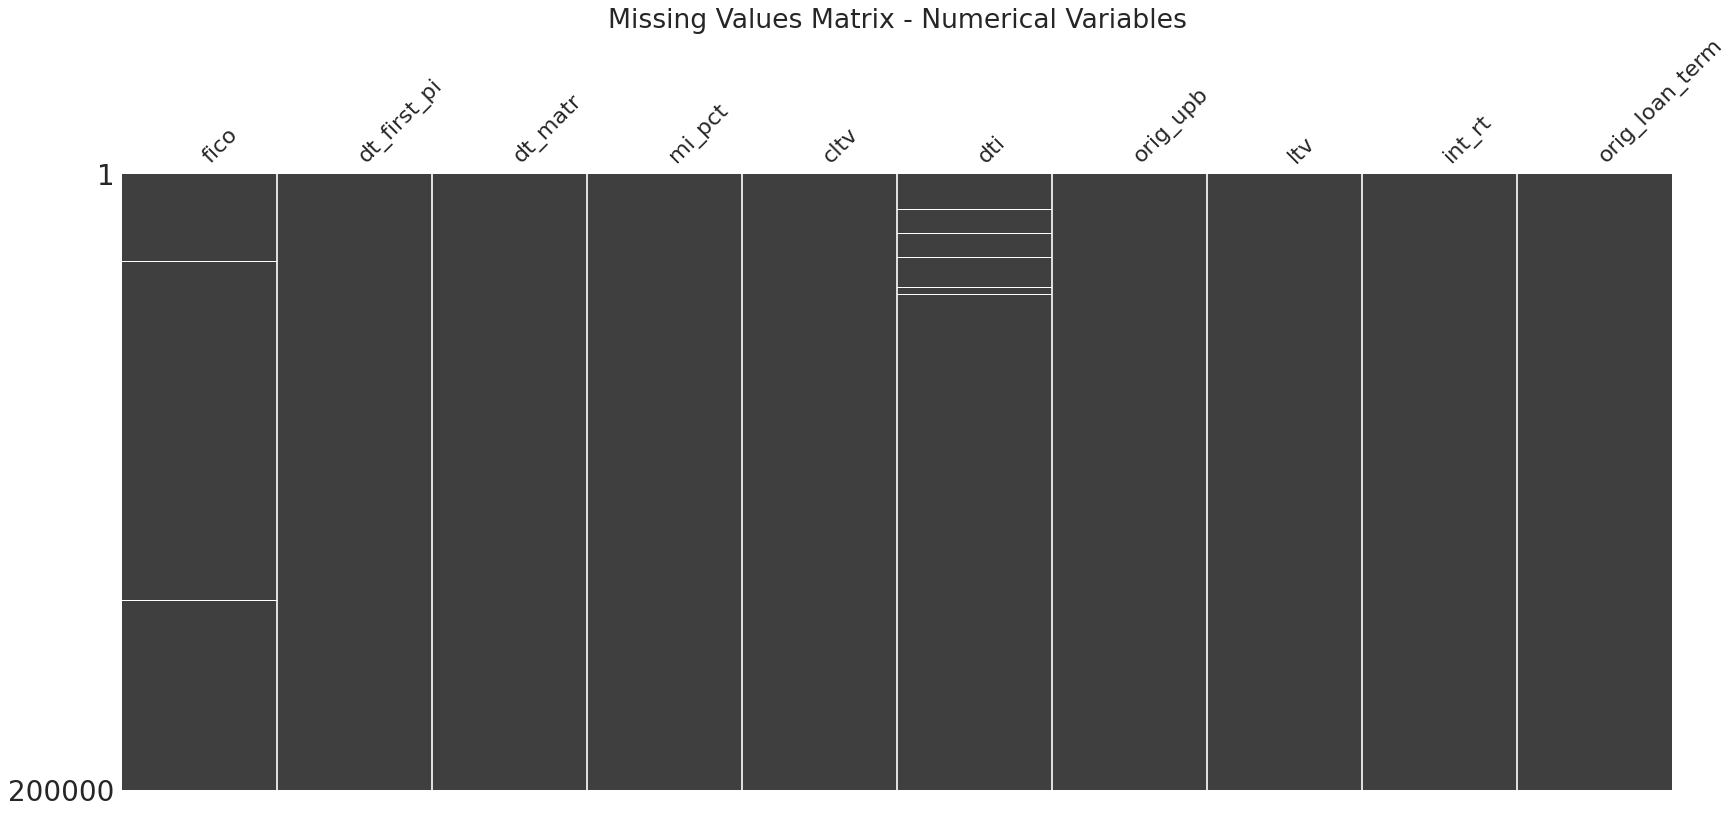

In [63]:
# classify categorical and numerical varaiables
categorical_columns = [
    'flag_fthb', 'occpy_sts', 'channel', 'st',
    'prop_type', 'loan_purpose', 'seller_name',
    'servicer_name', 'flag_sc', 'program_ind', 'rr_ind',
    'cd_msa', 'cnt_borr', 
    'property_val', 'mi_cancel_ind','cnt_units'
]

numerical_columns = [
    'fico', 'dt_first_pi', 'dt_matr',  'mi_pct',
     'cltv', 'dti', 'orig_upb', 'ltv',
    'int_rt', 'orig_loan_term'
]

# Convert categorical columns to 'object' dtype for consistency
d[categorical_columns] = d[categorical_columns].astype("object")

# plot missing values
msno.matrix(d[categorical_columns], fontsize=20, sparkline=False)
plt.title("Missing Values Matrix - Categorical Variables", fontsize = 24)
plt.show()

msno.matrix(d[numerical_columns], fontsize=20, sparkline=False)
plt.title("Missing Values Matrix - Numerical Variables", fontsize = 24)
plt.show()


通过分析我们发现大部分数据没有空值不需要填充，但是还是存在一些有空值的现象需要填充数据。
在这里我们填充数据的逻辑是：
1. 空值过多，直接删去这1列
2. 空值不多，分布呈现正态分布，我们对所有空值取mean
3. 空值不多，分布呈现偏态，我们对所有空值取median
4. 对于类别变量，对于有些列，我们直接取median（即最多的列）
5. 对于部分有特殊含义的类别变量，我们添加一个类别专门用来表示missing

具体填补操作
1. fico 呈现偏态分布，使用median填补空值
2. cd_msa 空值可能是非大都市区域，我们给空值添加一个missing类别
3. mi_pct 只有一个空，直接删去
4. cltv 只有6个空，直接删去
5. dti 偏态，median 填充
6. ltv 只有两个空，直接删去
7. flag_sc 空值的意义是否，添加新类别 将空值的类别设置为否
8. id_loan_rr 后面不用，不管
9. program_ind 空值可能有意义，加为新的missing类别
10. rr_ind 空值的意义是否，添加新类别 将空值的类别设置为否

In [48]:
# 根据填补规则填补数据，并且区分labeled

# 3. mi_pct：删除空值所在行
d = d[d['mi_pct'].notna()]

# 4. cltv：删除空值所在行
d = d[d['cltv'].notna()]

# 6. ltv：删除空值所在行
d = d[d['ltv'].notna()]

# 7. flag_sc：空值设为 'N'（表示否）
d['flag_sc'] = d['flag_sc'].fillna('N')

# 9. program_ind：空值设为新类别 'missing'
d['program_ind'] = d['program_ind'].fillna('missing')

# 10. rr_ind：空值设为 'N'（表示否）
d['rr_ind'] = d['rr_ind'].fillna('N')

# 仅根据值是否为 NA 或 'Not Available' 转换为两类
d['cd_msa'] = d['cd_msa'].apply(lambda x: 'Not Available' if pd.isna(x) or x == 'Not Available' else 'Available')


In [49]:
data_labeled = d[d['loan_status'].isin(['default', 'prepaid'])]

data_labeled['target'] = (data_labeled['loan_status'] == 'default').astype(int)

# 3. 定义用于建模的特征变量（你之前分好的数值 + 类别变量）
feature_columns = categorical_columns + numerical_columns

X = data_labeled[feature_columns]
y = data_labeled["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

eda_data = X_train.copy()
eda_data['loan_status'] = y_train  # 直接赋值，不用再做判断和转换


/tmp/ipykernel_81677/2647823557.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_labeled['target'] = (data_labeled['loan_status'] == 'default').astype(int)


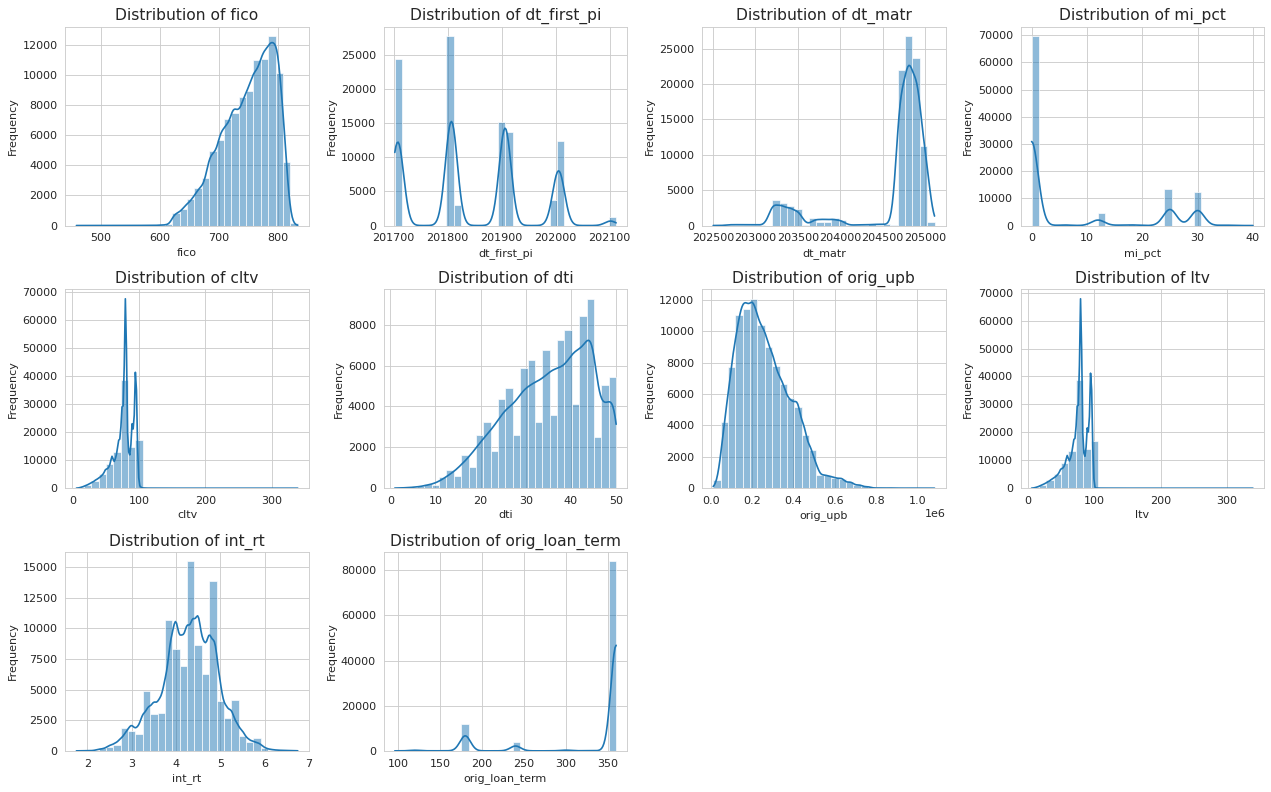

In [50]:
# 创建一个并排的图像画布，调整画布尺寸填满空间
# 计算行列数：最多 4 列，行数自动适配
n_cols = 4
n_rows = math.ceil(len(numerical_columns) / n_cols)

# 创建子图画布
fig, axes = plt.subplots(n_rows, n_cols,figsize=(16,10))
axes = axes.flatten()

# 绘图
for i, col in enumerate(numerical_columns):
    sns.histplot(eda_data[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}', fontsize=14)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# 去掉多余子图
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


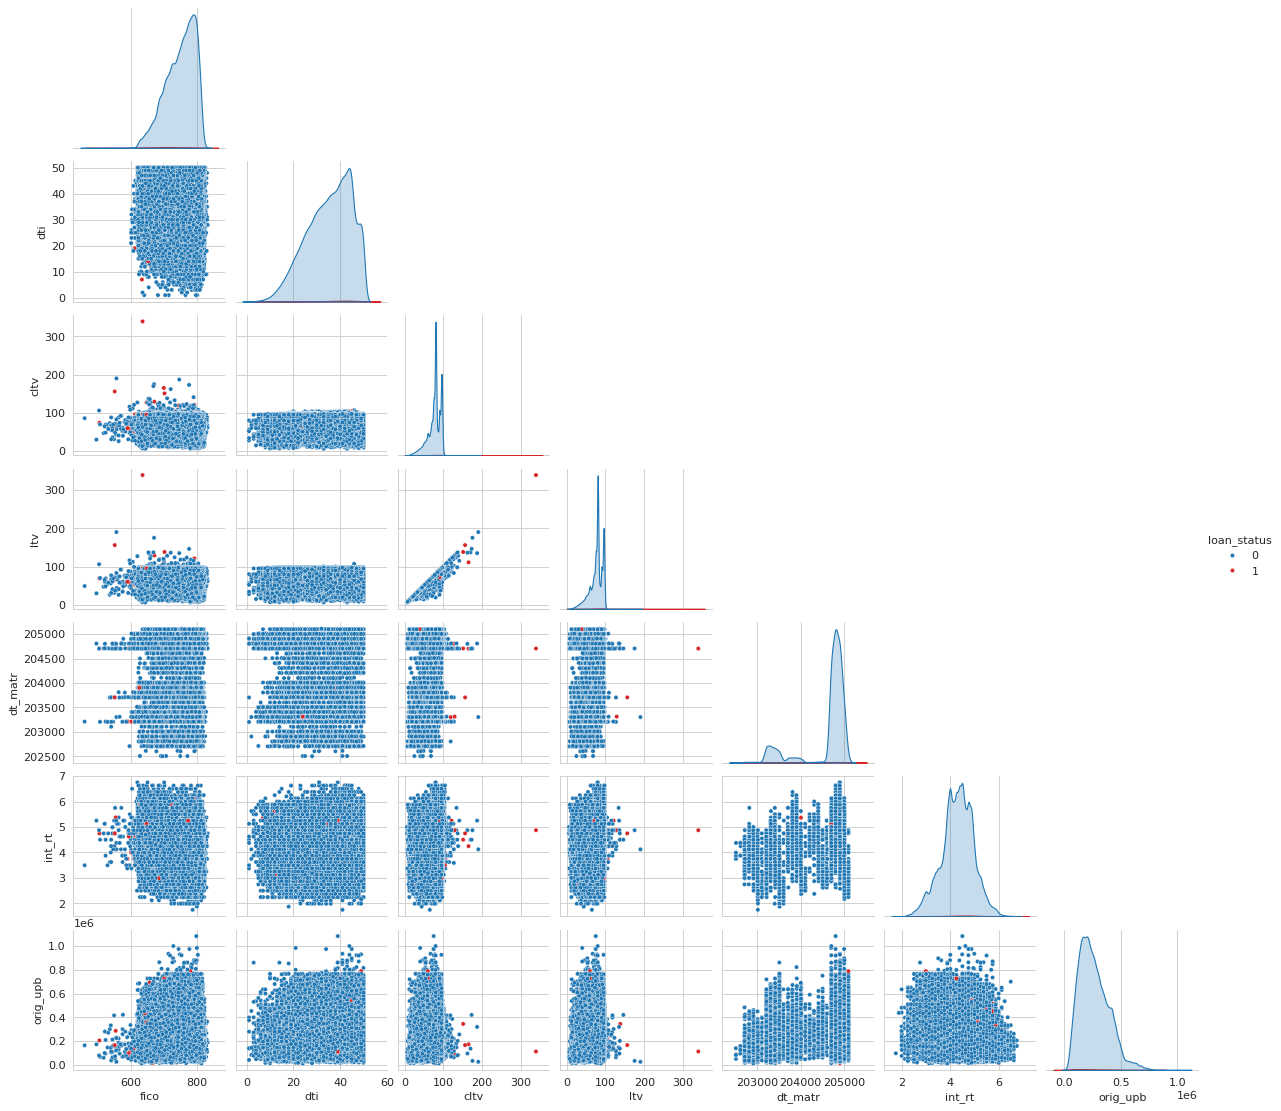

In [51]:
# 绘制 pairplot（成对关系图）
pair_vars = ['fico', 'dti', 'cltv', 'ltv' ,'dt_matr' , 'int_rt', 'orig_upb']

sns.pairplot(
    data=eda_data[pair_vars + ['loan_status']],
    hue='loan_status',
    palette=['#1f77b4','#d62728'],
    corner=True,
    plot_kws={'alpha': 1, 's': 15}
).fig.set_size_inches(16, 14)


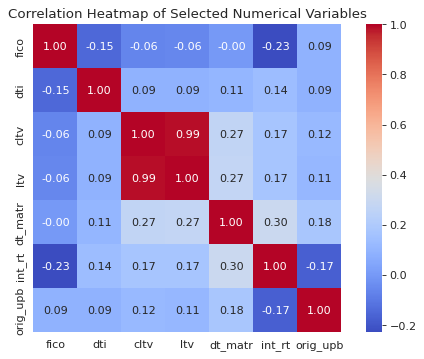

In [52]:
# 计算相关系数矩阵并画热力图
corr_matrix = eda_data[pair_vars].corr()
plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Heatmap of Selected Numerical Variables")
plt.show()

/tmp/ipykernel_81677/641040498.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='loan_status', y='fico', data=eda_data, palette='pastel', ax=axes[0])
/tmp/ipykernel_81677/641040498.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='loan_status', y='dti', data=eda_data, palette='pastel', ax=axes[1])


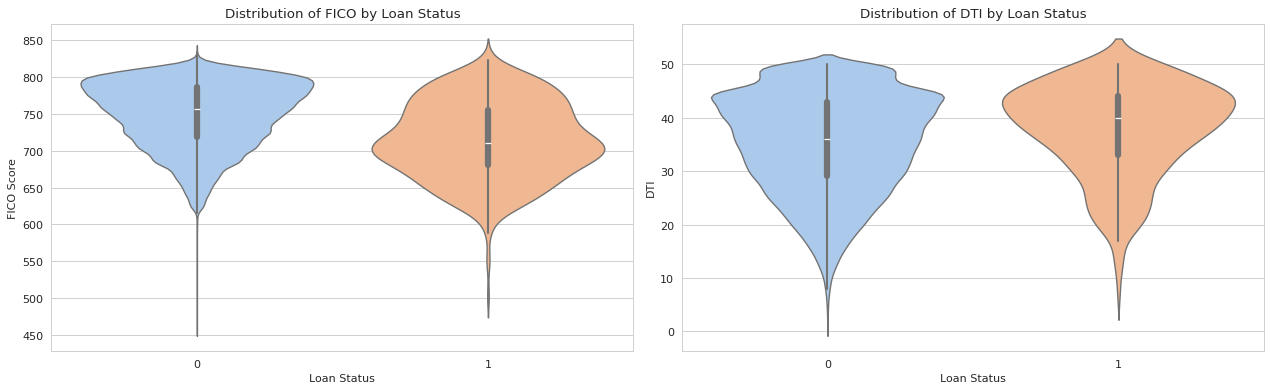

In [53]:
# 重画 violin plot
# 设置画布大小
fig, axes = plt.subplots(1, 2, figsize=(16, 5))  # 一行两列，整体宽度更适合展示

# FICO 分布图
sns.violinplot(x='loan_status', y='fico', data=eda_data, palette='pastel', ax=axes[0])
axes[0].set_title("Distribution of FICO by Loan Status")
axes[0].set_xlabel("Loan Status")
axes[0].set_ylabel("FICO Score")

# DTI 分布图
sns.violinplot(x='loan_status', y='dti', data=eda_data, palette='pastel', ax=axes[1])
axes[1].set_title("Distribution of DTI by Loan Status")
axes[1].set_xlabel("Loan Status")
axes[1].set_ylabel("DTI")

plt.tight_layout()
plt.show()



/tmp/ipykernel_81677/1083332644.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=var, y='loan_status', data=eda_data, palette='pastel', ax=axes[i], ci = None)
/tmp/ipykernel_81677/1083332644.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=var, y='loan_status', data=eda_data, palette='pastel', ax=axes[i], ci = None)
/tmp/ipykernel_81677/1083332644.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=var, y='loan_status', data=eda_data, palette='pastel', ax=axes[i], ci = None)
/tmp/ipykernel_81677/1083332644.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barp

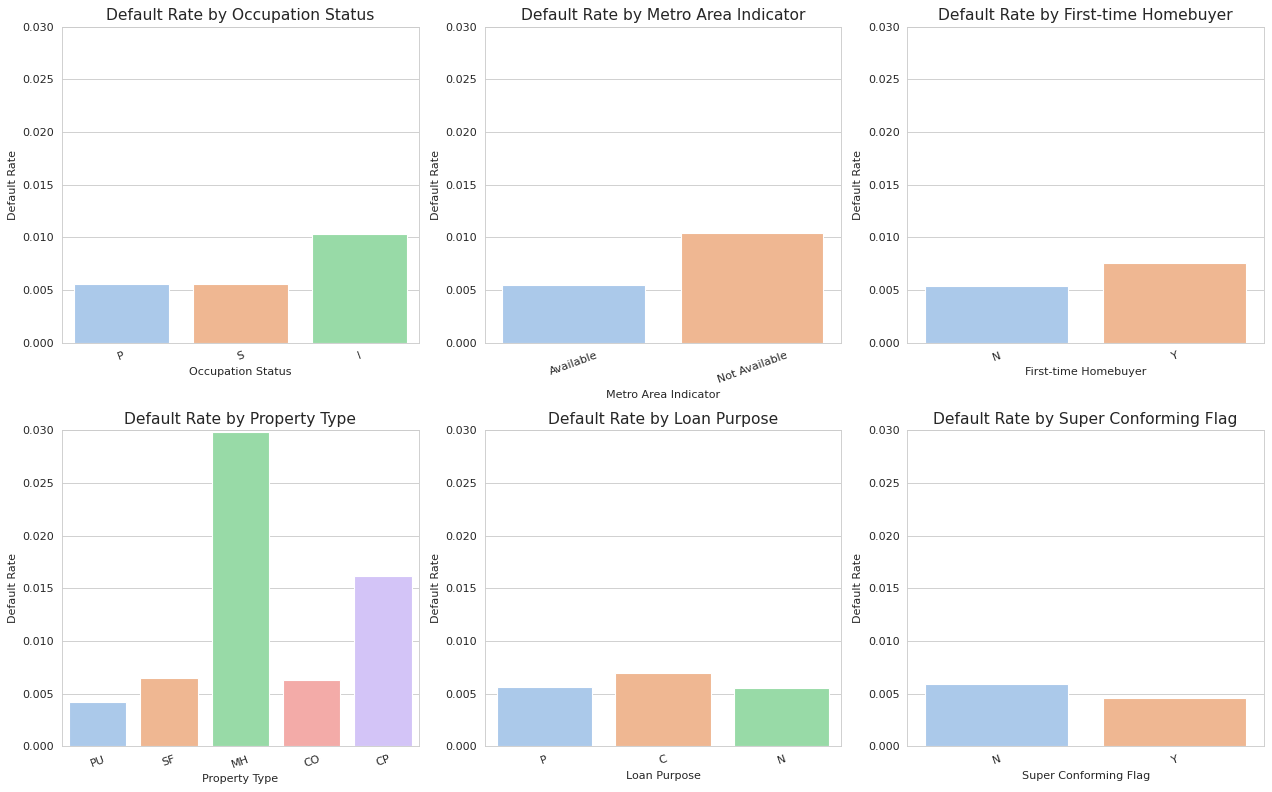

In [54]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (4, 5)
plt.rcParams['figure.dpi'] = 80

# 要绘图的分类变量和标题
categorical_vars = ['occpy_sts', 'cd_msa', 'flag_fthb', 'prop_type', 'loan_purpose', 'flag_sc']
titles = [
    "Occupation Status",
    "Metro Area Indicator",
    "First-time Homebuyer",
    "Property Type",
    "Loan Purpose",
    "Super Conforming Flag"
]

# 创建画布和子图 3 行 2 列
# 创建画布：2 行 3 列
fig, axes = plt.subplots(2, 3, figsize=(16, 10))  # 画布更宽一些
axes = axes.flatten()

# 画图
for i, var in enumerate(categorical_vars):
    sns.barplot(x=var, y='loan_status', data=eda_data, palette='pastel', ax=axes[i], ci = None)
    axes[i].set_title(f"Default Rate by {titles[i]}", fontsize=14)
    axes[i].set_xlabel(titles[i])
    axes[i].set_ylabel("Default Rate")
    axes[i].set_ylim(0, 0.03)  # 可以根据实际比例微调
    axes[i].tick_params(axis='x', rotation=20)

# 调整布局
plt.tight_layout()
plt.show()

# Model Fitting and Tuning

*In this section you should detail and motivate your choice of model and describe the process used to refine, tune, and fit that model. You are encouraged to explore different models but you should NOT include a detailed narrative or code of all of these attempts. At most this section should briefly mention the methods explored and why they were rejected - most of your effort should go into describing the final model you are using and your process for tuning and validating it.*

*This section should include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.*

*Finally, you should also provide a comparison of your model with a baseline model of your choice on the test data but only briefly describe the baseline model considered.*

In [55]:
# 2. 数值填补器（只针对 fico 和 dti）
numerical_imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# 3. 类别变量填补 + 编码器（空值填为'missing'再做独热编码）
categorical_imputer_encoder = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# 4. 合并为总的预处理器
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_imputer, ['fico', 'dti']),
    ('cat', categorical_imputer_encoder, categorical_columns)
], remainder='passthrough')

pipe = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000))
])

#X = data_labeled[feature_columns]
#y = data_labeled['target']

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

pipe.fit(X_train, y_train)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the ne

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['fico', 'dti']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['flag_fthb', 'occpy_sts',
                                                   'channel', 'st', 'prop_type',
                                                   'loan_purpose',
                                                   'seller_name',
                                                   'servicer_name', 'flag_sc',
                                                   'program_ind', 'rr_ind',
                                                   'cd_msa', 'cnt_borr',
                                                   'property_val',
                                                   'mi_cancel_ind',
                                                   'cnt_units'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

📊 评估指标 (baseline)
------------------------------
Accuracy       : 0.6886
Precision      : 0.0120
Recall         : 0.6376
F1 Score       : 0.0235
ROC AUC Score  : 0.7192


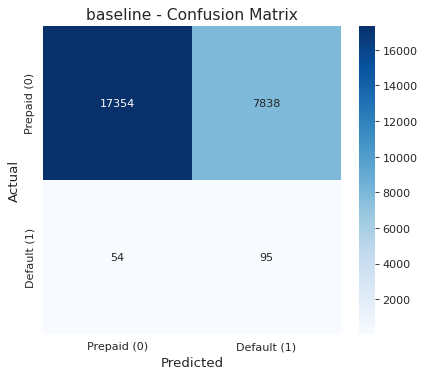

{'accuracy': 0.6885679333885798,
 'precision': 0.011975293079541156,
 'recall': 0.6375838926174496,
 'f1': 0.023509032417718387,
 'roc_auc': np.float64(0.7191616705846748),
 'confusion_matrix': array([[17354,  7838],
        [   54,    95]])}

In [56]:
classification_model_fit(pipe,X_test,y_test,model_name="baseline")

# Discussion & Conclusions

*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, estimated parameters and relationships, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of a banking official, who is understands the issues associated with mortgage defaults but may only have university level mathematics (not necessarily postgraduate statistics or machine learning). Your goal should be to highlight to this audience how your model can useful. You should also discuss potential limitations or directions of future improvement of your model.*

*Finally, you should include recommendations on factors that may increase the risk of default, which may be useful for the companies to improve their understanding of
mortgage defaults, and also to explain their decisions to clients and regulatory bodies. You should also use your model to inform the company of any active loans that are at risk of default.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*

# Generative AI statement

*Include a statement on how generative AI was used in the project and report.*

# References

*Include references if any*

In [56]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf project2.ipynb

[NbConvertApp] Converting notebook project2.ipynb to pdf
[NbConvertApp] ERROR | Error while converting 'project2.ipynb'
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.12/site-packages/nbconvert/nbconvertapp.py", line 487, in export_single_notebook
    output, resources = self.exporter.from_filename(
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/codespace/.local/lib/python3.12/site-packages/nbconvert/exporters/templateexporter.py", line 390, in from_filename
    return super().from_filename(filename, resources, **kw)  # type:ignore[return-value]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/codespace/.local/lib/python3.12/site-packages/nbconvert/exporters/exporter.py", line 201, in from_filename
    return self.from_file(f, resources=resources, **kw)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/codespace/.local/lib/python3.12/site-packages/nbconvert/exporters/templateexporter.py", li